In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from IPython.display import Image 

import math
import random
import codecs, json 

import cv2
import matplotlib.pyplot as plt

from sklearn import mixture
from scipy import linalg as la
from scipy import stats as st
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import numpy as np
from keras.layers import *
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf

In [2]:
c_maxnoise = np.array([[0.42, 0.18, 0.24, 0.26, 0.36, 0.42, 0.45, 0.44],
       [0.22, 0.21, 0.26, 0.31, 0.2 , 0.28, 0.22, 0.36],
       [0.18, 0.14, 0.12, 0.37, 0.12, 0.14, 0.29, 0.32],
       [0.2 , 0.3 , 0.29, 0.13, 0.23, 0.15, 0.3 , 0.23],
       [0.31, 0.1 , 0.14, 0.28, 0.29, 0.31, 0.18, 0.38],
       [0.42, 0.23, 0.37, 0.31, 0.18, 0.34, 0.24, 0.3 ],
       [0.29, 0.26, 0.34, 0.3 , 0.15, 0.3 , 0.35, 0.28],
       [0.39, 0.46, 0.32, 0.42, 0.43, 0.37, 0.46, 0.4 ]])

def read_tempdata2(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
#     arr = arr - c_error
    arr = np.amax(arr, axis = 0) - c_maxnoise
    return arr

def read_tempdata(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
    return arr

def read_gtempdata(rn,gpath,num):
    garr = np.zeros([num,rn,8,8])
    for n in range(num):
        path = gpath + str(n+1) +'.txt'
        garr[n] = read_tempdata(rn, path)
    return garr

In [3]:
dis_head = np.linspace(1,4,4)
poly_dis = np.zeros((4,4))
amb_temp = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
amb_dis = np.array([[ 2.16,  2.13,  2.06,  2.21],
       [ 0.62,  0.56,  1.03,  1.46],
       [-1.57, -1.58, -0.21,  0.56],
       [-3.26, -2.5 , -1.93, -1.73]])

for i in range(4):
    poly_dis[i] = np.polyfit(dis_head,amb_dis[i],3)
    
def get_bodytemp(temp,ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return (temp - ans + 6.740361118467977).round(2)
    
def get_shifttemp(ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return ans - 6.740361118467977

In [4]:
points = [(math.floor(ix / 8), (ix % 8)) for ix in range(0, 64)]
grid_x, grid_y = np.mgrid[0:7:64j, 0:7:64j]

def get_weight(garr,arrbg):
    diff = garr.reshape(-1,64)-arrbg.reshape(-1)

    weight = np.ones(diff.shape[0])
    for i in range(diff.shape[0]):
        bicubic = np.around(griddata(points, diff[i], (grid_x, grid_y), method='cubic').reshape(-1) * 4)/4.

        gmm = mixture.GaussianMixture(n_components = 2)
        gmm = gmm.fit(X=bicubic.reshape(-1,1))
        gmm_x = np.linspace(np.amin(bicubic),np.amax(bicubic),100)
        gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))
        gmm_y2 = gmm.predict_proba(gmm_x.reshape(-1,1))
        if np.argmax(gmm_y2[:,0]*gmm_y) > np.argmax(gmm_y2[:,1]*gmm_y):
            gmm_y2[:,[0,1]] = gmm_y2[:,[1,0]]
        weight[i] = gmm_x[np.argmax(gmm_y2[:,0]*gmm_y)]
        
    return weight

In [5]:
def show_temp(arr, mintemp = 26, maxtemp = 32):
    plt.figure(figsize=(6,5))
    bicubic = griddata(points, arr.reshape(-1), (grid_x, grid_y), method='cubic')
    pcm = plt.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = mintemp, vmax = maxtemp)
    plt.colorbar(pcm, fraction=0.175,pad=0.02)
    plt.axis('off')
    plt.show()
    
    return np.amax(bicubic)


In [6]:
def thermal_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx,8,8))
    garr2 = garr.reshape((oy,ox,8,8))
    for i in range(ny):
        for j in range(nx):
            if nx == 1:
                y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
                y1 = y2-1
                ly = i*(oy-1)/(ny-1) - y1
                interpol[i,j] = garr2[y1,j-1]*(1-ly)+garr2[y2,j-1]*ly
                continue
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def reg_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx))
    garr2 = garr.reshape((oy,ox))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def output_interpolate(temp_path, ln2, dis):
    interpol = np.zeros((4,ln2**2,100,8,8))
    ln = 6
    bg_max = 0
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

        garr = read_gtempdata(100,datapath,ln**2)

        interpol[i] = thermal_interpolate(garr,ln**2,100,ln2**2,100)
        ln -= 1
    interpol = thermal_interpolate(interpol,4,(ln2**2)*100,dis,(ln2**2)*100)
    return interpol


def load_temperature():
    ln = 6
    dis = 16
    x_train = np.zeros((4,dis,ln**2,100,8,8))
#     arrbg = np.zeros((4,1,8,8))
    temp_path = np.array(['hot','warm','semicold','cold'])
    for i in range(4):
        bgpath = 'train/' + temp_path[i] + '/output-empty/1.txt'
#         arrbg[i] = read_tempdata2(100,bgpath)
        x_train[i] = output_interpolate(temp_path[i],ln,dis).reshape(dis,ln**2,100,8,8)
#     arrbg = thermal_interpolate(arrbg,4,1,16,1)
    x_train = thermal_interpolate(x_train,4,(ln**2)*100*dis,16,(ln**2)*100*dis)
    x_train = x_train.reshape(16,-1,100,8,8,1).transpose(1,0,2,3,4,5)
    print("interpolation complete")
    
    
    temp_arr = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
    temp_inter = np.zeros(16)
    for i in range(3):
        temp_inter[i*5:(i+1)*5+1] = np.linspace(temp_arr[i],temp_arr[i+1],6)
        
    y_train = np.ones((5,16,dis,ln**2))

    y_train[1] = (np.ones((dis,ln**2,16))*temp_inter).transpose(2,0,1)
    y_train[2] = (np.ones((16,ln**2,dis))*np.linspace(1,4,dis)).transpose(0,2,1)
    pos_x = np.array([np.linspace(1,6,6),]*6)
    pos_y = pos_x.T
    y_train[3] = (np.ones((16,dis,ln**2))*pos_x.reshape(-1))
    y_train[4] = (np.ones((16,dis,ln**2))*pos_y.reshape(-1))
    y_train = y_train.reshape(5,-1)
    print("y_train[1-4] complete")
    mu, sigma = 36.5, 0.875 # mean and standard deviation
    y_temp = np.clip(np.random.normal(mu, sigma,y_train.shape[1]), 36,40)
    ol_skintemp = np.ones((y_train.shape[1]))
    y_amb = np.copy(y_train[1])
    for i in range(y_train.shape[1]):
        _a = y_train[1,i]
        _b = y_train[2,i]
        ol_skintemp[i] = 36.5 + get_shifttemp(_a,_b)
        
        y_temp[i] += get_shifttemp(_a,_b)
        y_train[0,i] = (y_temp[i]-29)/7
#         print([ol_skintemp[i],y_temp[i],y_amb[i]])
#         y_train[0,i] = (36.5-37.5)/2.5
    y_train[1] = (y_train[1]/25) -1
    y_train = y_train.reshape(5,16,-1).transpose(2,1,0)
    y_amb = y_amb.reshape(16,-1).transpose(1,0)
    ol_skintemp = ol_skintemp.reshape(16,-1).transpose(1,0)
    y_temp = y_temp.reshape(16,-1).transpose(1,0)
    
    print("y_train complete")
    x_train2 = []
    y_train2 = []
    for k in range(16):
        for i in range(x_train.shape[0]):
#             print(i)
            for j in range(i+1,x_train.shape[0]):
                
                _a = random.randint(0,99)
                _b = random.randint(0,99)
                 #add noise
                mu, sigma = 0, 0.08 # mean and standard deviation
                _na = np.clip(np.random.normal(mu, sigma, 5)*np.array([0,0,1,1,1]),-0.16,0.16)
                _nb = np.clip(np.random.normal(mu, sigma, 5)*np.array([0,0,1,1,1]),-0.16,0.16)
                y_train2.append(y_train[i,k]+_na)
                y_train2.append(y_train[j,k]+_nb)
                y_train2.append(y_train[i,k]+_na)
                y_train2.append(y_train[j,k]+_nb)
                
                _x = np.zeros((2,8,8,1))
                _xo = np.zeros((2,8,8,1))
                _xo[0] = x_train[i,k,_a]
                _xo[1] = x_train[j,k,_b]
                _x[0] = np.clip((_xo[0]-y_amb[i,k]-0.5)/(ol_skintemp[i,k]-y_amb[i,k]-0.5),0,1)
                _x[1] = np.clip((_xo[1]-y_amb[j,k]-0.5)/(ol_skintemp[j,k]-y_amb[j,k]-0.5),0,1)
                _x[0] = _x[0]*(y_temp[i,k]) + (1-_x[0])*(_xo[0]+0.5) 
                _x[1] = _x[1]*(y_temp[j,k]) + (1-_x[1])*(_xo[1]+0.5)
#                 weight = get_weight(_x,arrbg[k])
#                 wmean = np.mean(weight)
#                 _x = (_x.transpose(1,2,3,0) -(weight-wmean)).transpose(3,0,1,2)
                _xx = np.amax(_x, axis = 0)
                x_train2.append(_xx)
                x_train2.append(_xx)
                x_train2.append(_x[0])
                x_train2.append(_x[1])
                
                
               
    del x_train, y_train
    x_train2 = np.array(x_train2)
    y_train2 = np.array(y_train2)
    
    
    indices = np.arange(x_train2.shape[0])
    np.random.shuffle(indices)
    
    ind = math.floor(x_train2.shape[0]*0.2)
    return x_train2[indices[:-ind]],y_train2[indices[:-ind],2:], y_train2[indices[:-ind],:2], x_train2[indices[-ind:]], y_train2[indices[-ind:],2:],y_train2[indices[-ind:],:2]

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 8, 1)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 64)     640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 8, 8, 64)     256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 8, 8, 64)     0           batch_normalization[0][0]        
_______________________________________________________________________________________

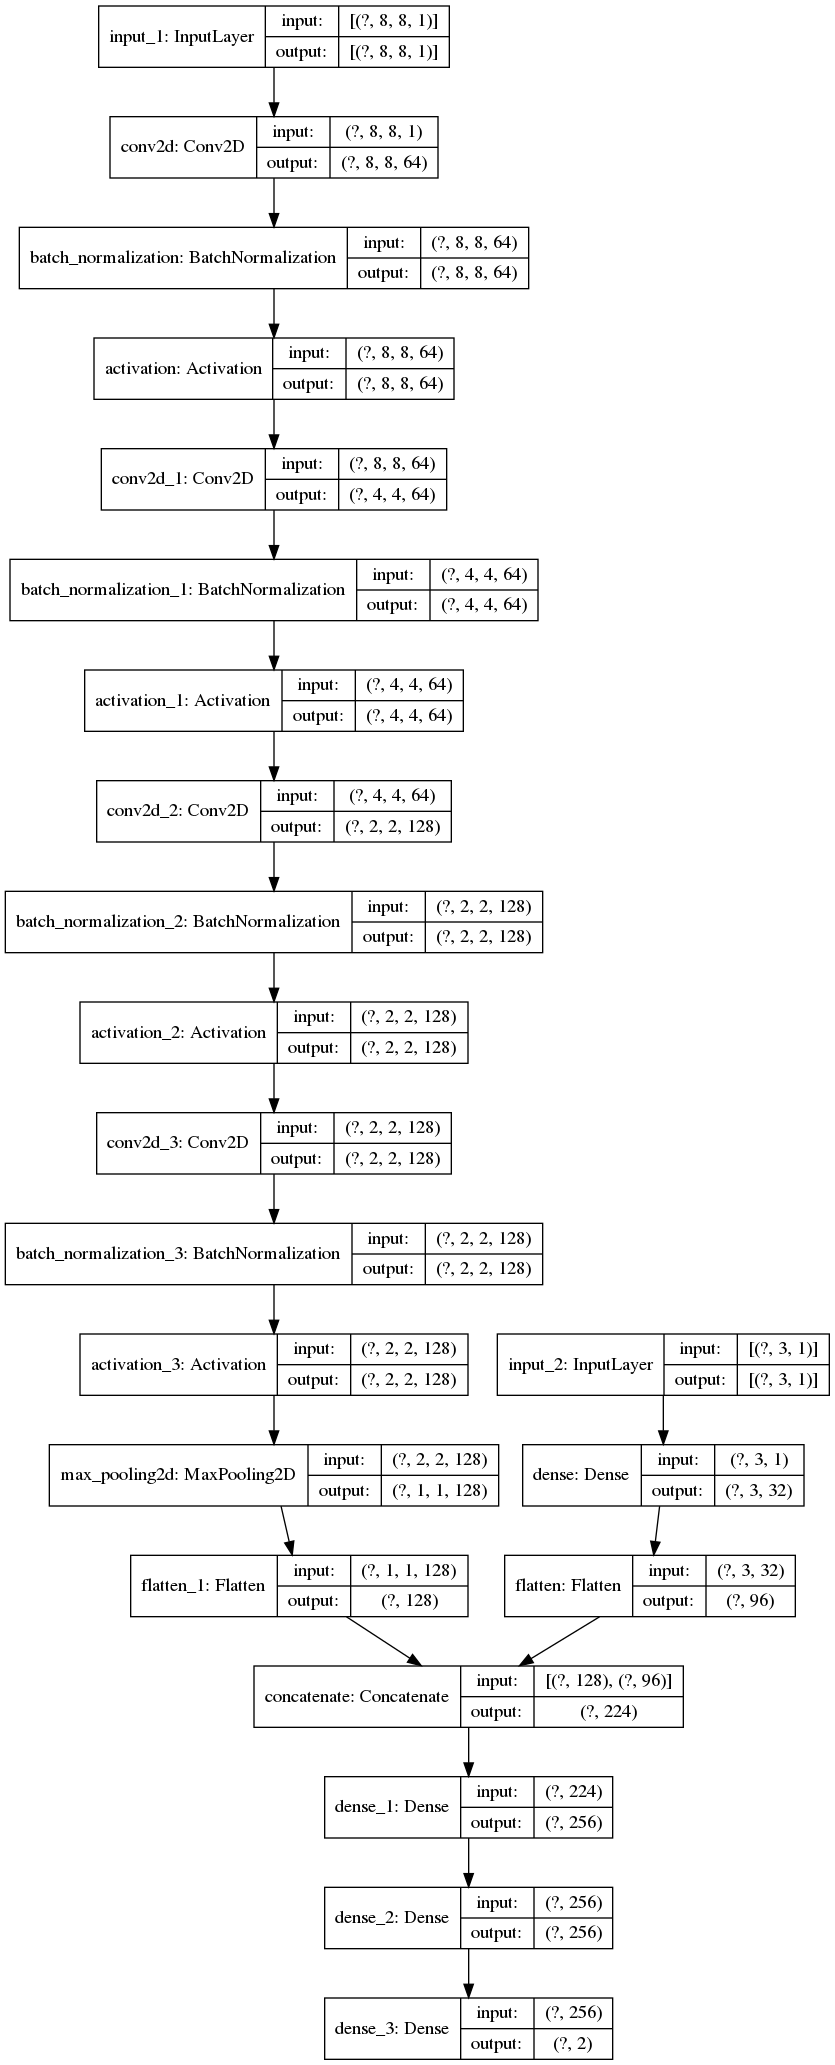

In [7]:
input_shape = (8,8,1)
input_shape2 = (3,1)
kernel_size = 3
filters = 64
dropout = 0.3
init = RandomNormal(stddev=0.02)

inputs = Input(shape=input_shape)
inputs2 = Input(shape=input_shape2)

y = Conv2D(filters=filters,
           kernel_size=kernel_size,
          padding = 'same')(inputs)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
          strides = 2,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
# y = MaxPooling2D()(y)
y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
          strides = 2,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = MaxPooling2D()(y)


y2 = Dense(32, activation='relu')(inputs2)
y2 = Flatten()(y2)


y = Flatten()(y)
y = Concatenate()([y,y2])
y = Dense(filters*4, activation='relu')(y)
y = Dense(filters*4, activation='relu')(y)
outputs = Dense(2, activation='tanh')(y)

model = Model(inputs=[inputs,inputs2], outputs=[outputs])
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

In [8]:
acc = []
val_acc = []
loss = []
val_loss = []

In [9]:
# from tensorflow import keras
# model = keras.models.load_model('multi_model.h5')

In [10]:
opt = Adam(lr=0.0003, beta_1=0.9)
model.compile(loss='mae',
              optimizer= opt,
              metrics=['accuracy'])

batch_size = 256
x_train, x_train2, y_train, x_test, x_test2, y_test = load_temperature()
for i in range(40):
    history = model.fit([x_train,x_train2],
          y_train,
          validation_data=([x_test,x_test2], y_test),
          epochs=5,
          batch_size=batch_size)
    acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
#     del x_train, x_train2, y_train, x_test, x_test2, y_test

interpolation complete
y_train[1-4] complete
y_train complete
Epoch 1/5
33120/33120 [==============================] - 107s 3ms/step - loss: 0.0348 - accuracy: 0.9040 - val_loss: 0.0368 - val_accuracy: 0.9069
Epoch 2/5
33120/33120 [==============================] - 107s 3ms/step - loss: 0.0278 - accuracy: 0.9239 - val_loss: 0.0287 - val_accuracy: 0.9218
Epoch 3/5
33120/33120 [==============================] - 107s 3ms/step - loss: 0.0250 - accuracy: 0.9325 - val_loss: 0.0291 - val_accuracy: 0.9252
Epoch 4/5
33120/33120 [==============================] - 108s 3ms/step - loss: 0.0234 - accuracy: 0.9369 - val_loss: 0.0257 - val_accuracy: 0.9309
Epoch 5/5
33120/33120 [==============================] - 108s 3ms/step - loss: 0.0223 - accuracy: 0.9398 - val_loss: 0.0278 - val_accuracy: 0.9266
Epoch 1/5
33120/33120 [==============================] - 109s 3ms/step - loss: 0.0215 - accuracy: 0.9416 - val_loss: 0.0222 - val_accuracy: 0.9392
Epoch 2/5
33120/33120 [==============================] -

33120/33120 [==============================] - 112s 3ms/step - loss: 0.0162 - accuracy: 0.9534 - val_loss: 0.0166 - val_accuracy: 0.9525
Epoch 2/5
33120/33120 [==============================] - 111s 3ms/step - loss: 0.0161 - accuracy: 0.9535 - val_loss: 0.0170 - val_accuracy: 0.9520
Epoch 3/5
33120/33120 [==============================] - 111s 3ms/step - loss: 0.0161 - accuracy: 0.9536 - val_loss: 0.0181 - val_accuracy: 0.9477
Epoch 4/5
33120/33120 [==============================] - 111s 3ms/step - loss: 0.0161 - accuracy: 0.9536 - val_loss: 0.0179 - val_accuracy: 0.9509
Epoch 5/5
33120/33120 [==============================] - 111s 3ms/step - loss: 0.0161 - accuracy: 0.9537 - val_loss: 0.0165 - val_accuracy: 0.9533
Epoch 1/5
33120/33120 [==============================] - 112s 3ms/step - loss: 0.0161 - accuracy: 0.9537 - val_loss: 0.0164 - val_accuracy: 0.9531
Epoch 2/5
33120/33120 [==============================] - 112s 3ms/step - loss: 0.0160 - accuracy: 0.9537 - val_loss: 0.0199 - va

Epoch 2/5
33120/33120 [==============================] - 111s 3ms/step - loss: 0.0153 - accuracy: 0.9554 - val_loss: 0.0157 - val_accuracy: 0.9549
Epoch 3/5
33120/33120 [==============================] - 109s 3ms/step - loss: 0.0153 - accuracy: 0.9554 - val_loss: 0.0163 - val_accuracy: 0.9515
Epoch 4/5
33120/33120 [==============================] - 109s 3ms/step - loss: 0.0153 - accuracy: 0.9555 - val_loss: 0.0157 - val_accuracy: 0.9548
Epoch 5/5
33120/33120 [==============================] - 110s 3ms/step - loss: 0.0153 - accuracy: 0.9555 - val_loss: 0.0191 - val_accuracy: 0.9470
Epoch 1/5
33120/33120 [==============================] - 110s 3ms/step - loss: 0.0153 - accuracy: 0.9555 - val_loss: 0.0159 - val_accuracy: 0.9539
Epoch 2/5
33120/33120 [==============================] - 111s 3ms/step - loss: 0.0153 - accuracy: 0.9555 - val_loss: 0.0160 - val_accuracy: 0.9536
Epoch 3/5
33120/33120 [==============================] - 110s 3ms/step - loss: 0.0153 - accuracy: 0.9555 - val_loss: 0

Epoch 3/5
33120/33120 [==============================] - 108s 3ms/step - loss: 0.0149 - accuracy: 0.9563 - val_loss: 0.0161 - val_accuracy: 0.9549
Epoch 4/5
33120/33120 [==============================] - 108s 3ms/step - loss: 0.0150 - accuracy: 0.9563 - val_loss: 0.0156 - val_accuracy: 0.9534
Epoch 5/5
33120/33120 [==============================] - 108s 3ms/step - loss: 0.0149 - accuracy: 0.9563 - val_loss: 0.0156 - val_accuracy: 0.9532
Epoch 1/5
33120/33120 [==============================] - 110s 3ms/step - loss: 0.0149 - accuracy: 0.9563 - val_loss: 0.0155 - val_accuracy: 0.9546
Epoch 2/5
33120/33120 [==============================] - 110s 3ms/step - loss: 0.0149 - accuracy: 0.9563 - val_loss: 0.0158 - val_accuracy: 0.9548
Epoch 3/5
33120/33120 [==============================] - 110s 3ms/step - loss: 0.0149 - accuracy: 0.9563 - val_loss: 0.0159 - val_accuracy: 0.9534
Epoch 4/5
33120/33120 [==============================] - 109s 3ms/step - loss: 0.0149 - accuracy: 0.9564 - val_loss: 0

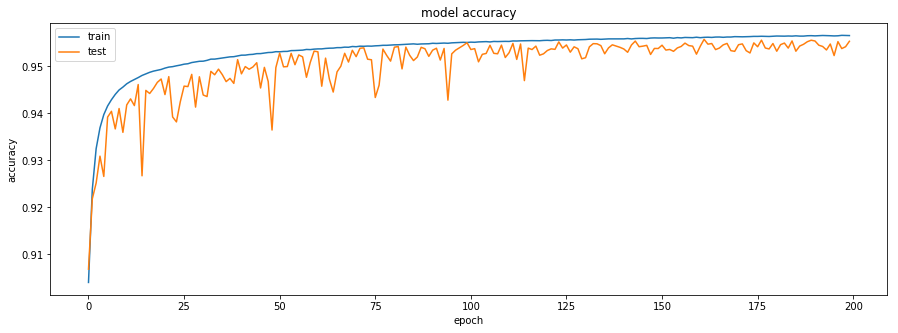

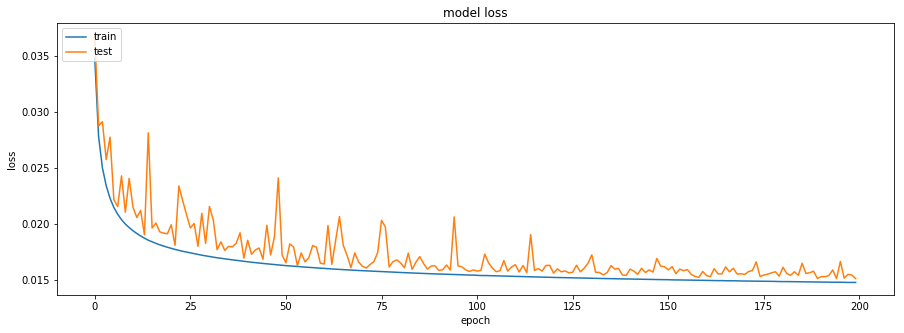

In [11]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(np.array(acc).reshape(-1))
plt.plot(np.array(val_acc).reshape(-1))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15, 5))
plt.plot(np.array(loss).reshape(-1))
plt.plot(np.array(val_loss).reshape(-1))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [12]:
model.save('multi_model3.h5')

In [13]:
acc

[[0.9040371775627136,
  0.9238613843917847,
  0.9325054883956909,
  0.9369336366653442,
  0.9397504329681396],
 [0.9415943622589111,
  0.9429221749305725,
  0.9440585374832153,
  0.9449984431266785,
  0.9456110000610352],
 [0.9463135004043579,
  0.9468143582344055,
  0.947223424911499,
  0.9476380944252014,
  0.9480903744697571],
 [0.948415219783783,
  0.9487566351890564,
  0.9490123391151428,
  0.9491881132125854,
  0.9493677020072937],
 [0.9496532678604126,
  0.9498677849769592,
  0.94996178150177,
  0.9501410722732544,
  0.9502920508384705],
 [0.950488269329071,
  0.950581431388855,
  0.9508363008499146,
  0.9509588479995728,
  0.9511016011238098],
 [0.9511255025863647,
  0.9513038396835327,
  0.9515576362609863,
  0.9515661597251892,
  0.9516811370849609],
 [0.9517896771430969,
  0.9519309401512146,
  0.9520438313484192,
  0.9520845413208008,
  0.9522423148155212],
 [0.9524040222167969,
  0.9524134397506714,
  0.9525325894355774,
  0.9525827169418335,
  0.9527290463447571],
 [0.952

In [14]:
val_acc

[[0.9068637490272522,
  0.9218443632125854,
  0.9251939058303833,
  0.9309155344963074,
  0.9265993237495422],
 [0.9392276406288147,
  0.9404599070549011,
  0.9367126226425171,
  0.941047728061676,
  0.9359809160232544],
 [0.9418195486068726,
  0.9431065320968628,
  0.9416765570640564,
  0.9461531639099121,
  0.9267328381538391],
 [0.9449062943458557,
  0.9442510008811951,
  0.9453219175338745,
  0.9466150403022766,
  0.9473326206207275],
 [0.9440169930458069,
  0.9478374123573303,
  0.939255952835083,
  0.9382033944129944,
  0.9424620866775513],
 [0.9458191990852356,
  0.9457187056541443,
  0.9483176469802856,
  0.9413543343544006,
  0.9478062987327576],
 [0.9439283013343811,
  0.9436028003692627,
  0.9489654302597046,
  0.9482346177101135,
  0.9494305849075317],
 [0.9482530355453491,
  0.9467778205871582,
  0.9474642276763916,
  0.946401834487915,
  0.9514492750167847],
 [0.9484328031539917,
  0.94997638463974,
  0.9494098424911499,
  0.9498924612998962,
  0.950796365737915],
 [0.945

In [15]:
loss

[[0.03478187695145607,
  0.027830470353364944,
  0.025030437856912613,
  0.023417716845870018,
  0.022310148924589157],
 [0.021484114229679108,
  0.02088579349219799,
  0.02039964310824871,
  0.020010149106383324,
  0.01969415321946144],
 [0.019409513100981712,
  0.01916758343577385,
  0.018950439989566803,
  0.01874922402203083,
  0.01857113093137741],
 [0.018428979441523552,
  0.018286501988768578,
  0.01816188357770443,
  0.01805168204009533,
  0.017941037192940712],
 [0.017843930050730705,
  0.017747873440384865,
  0.017665622755885124,
  0.017582764849066734,
  0.017511343583464622],
 [0.017436068505048752,
  0.01736491546034813,
  0.01729593239724636,
  0.017233924940228462,
  0.01717238686978817],
 [0.017117977142333984,
  0.017062179744243622,
  0.017003795132040977,
  0.01696135848760605,
  0.01690724864602089],
 [0.01686316542327404,
  0.016813067719340324,
  0.016769517213106155,
  0.016727421432733536,
  0.01669173501431942],
 [0.016647985205054283,
  0.016605539247393608,


In [16]:
val_loss

[[0.03682098537683487,
  0.028748033568263054,
  0.029131969437003136,
  0.02574734576046467,
  0.02775132842361927],
 [0.02218743786215782,
  0.021570181474089622,
  0.02430182881653309,
  0.0210618544369936,
  0.02407672256231308],
 [0.021512391045689583,
  0.020591281354427338,
  0.021229814738035202,
  0.019049255177378654,
  0.02814055234193802],
 [0.01965218596160412,
  0.02009792998433113,
  0.019316580146551132,
  0.01920127496123314,
  0.019141850993037224],
 [0.01994972862303257,
  0.018119117245078087,
  0.02340412139892578,
  0.022091832011938095,
  0.02084987424314022],
 [0.019660960882902145,
  0.020056424662470818,
  0.018023019656538963,
  0.02096710354089737,
  0.01827901415526867],
 [0.02157849632203579,
  0.020367832854390144,
  0.01772947423160076,
  0.018422158434987068,
  0.017665335908532143],
 [0.018018068745732307,
  0.01798137277364731,
  0.01829819567501545,
  0.019226286560297012,
  0.01697254367172718],
 [0.018563805148005486,
  0.017309540882706642,
  0.01

In [17]:
x_train, x_train2, y_train, x_test, x_test2, y_test = load_temperature()

interpolation complete
y_train[1-4] complete
y_train complete


In [18]:
res = np.array(model.predict([x_test, x_test2])*np.array([7,25])+np.array([29,25]))

In [19]:
def get_bodytemp(temp,ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return (temp - ans + 6.740361118467977).round(2)

In [20]:
l = []
for i in range(100):
    l.append(abs(get_bodytemp(res[i,0],res[i,1],x_test2[i,0]) - get_bodytemp(y_test[i,0]*7+29,y_test[i,1]*25+25,x_test2[i,0])))
np.median(np.array(l))

0.3399999999999963

In [21]:
for i in range(100):
    print(get_bodytemp(res[i,0],res[i,1],x_test2[i,0]))

36.04
36.32
35.98
36.43
36.34
36.39
36.16
37.18
36.92
37.43
37.29
36.54
37.37
38.82
36.52
37.72
36.34
36.95
36.2
36.68
36.6
36.04
37.68
36.57
36.59
37.37
38.07
38.32
36.4
36.11
36.89
35.91
37.2
35.92
35.95
36.62
36.14
36.49
37.55
37.01
36.52
36.15
37.17
36.15
35.86
36.11
36.42
36.56
36.38
36.47
36.4
35.98
36.77
36.47
36.3
37.07
36.02
36.54
36.43
37.01
37.06
35.9
35.97
36.86
35.98
36.66
36.82
36.03
36.08
36.74
36.14
36.04
36.22
36.85
35.96
36.09
36.42
36.19
36.56
37.52
36.11
36.15
36.16
36.19
36.39
36.02
37.68
36.33
36.73
36.86
35.81
36.63
36.65
36.97
37.45
37.48
36.62
36.1
36.52
36.3


In [22]:
for i in range(100):
    a = get_bodytemp(res[i,0],res[i,1],x_test2[i,0])
    b = get_bodytemp(y_test[i,0]*7+29,y_test[i,1]*25+25,x_test2[i,0])
    if abs(a - b) >= 1:
        print([a,b,a - b])

[38.82, 35.99, 2.8299999999999983]
[37.72, 35.98, 1.740000000000002]
[37.68, 36.55, 1.1300000000000026]
[38.07, 36.88, 1.1899999999999977]
[38.32, 35.95, 2.3699999999999974]
[35.91, 39.09, -3.180000000000007]
[37.2, 36.01, 1.1900000000000048]
[37.55, 36.08, 1.4699999999999989]
[37.01, 36.0, 1.009999999999998]
[36.47, 38.23, -1.759999999999998]
[36.42, 38.63, -2.210000000000001]
[36.19, 37.44, -1.25]
[36.02, 38.34, -2.3200000000000003]
[37.45, 36.04, 1.4100000000000037]


In [24]:
score = model.evaluate([x_test,x_test2], y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))

8280/8280 [==============================] - 10s 1ms/step - loss: 0.0421 - accuracy: 0.8705

Test accuracy: 87.0%


In [23]:
# acc = [[0.8956189155578613,
#   0.9171227216720581,
#   0.9272516369819641,
#   0.9323793053627014,
#   0.9356287121772766],
#  [0.9292052388191223,
#   0.9394311904907227,
#   0.9428248405456543,
#   0.9448370933532715,
#   0.946162760257721],
#  [0.9291677474975586,
#   0.9394189119338989,
#   0.9424757361412048,
#   0.9443004131317139,
#   0.9454392790794373],
#  [0.9307454228401184,
#   0.9413160085678101,
#   0.9440813064575195,
#   0.9456913471221924,
#   0.946844220161438],
#  [0.9289882183074951,
#   0.9404796957969666,
#   0.9436443448066711,
#   0.9453481435775757,
#   0.9464625716209412],
#  [0.9295472502708435,
#   0.9416108727455139,
#   0.9446308016777039,
#   0.9462156891822815,
#   0.9474599957466125],
#  [0.9294997453689575,
#   0.9406997561454773,
#   0.9440943002700806,
#   0.9459648132324219,
#   0.9472061991691589],
#  [0.9271018505096436,
#   0.9395248293876648,
#   0.9426289796829224,
#   0.94455486536026,
#   0.9458598494529724]]
# val_acc = [[0.9051729440689087,
#   0.9191420674324036,
#   0.9219802021980286,
#   0.9149919152259827,
#   0.9325639009475708],
#  [0.9277636408805847,
#   0.9362290501594543,
#   0.9406986236572266,
#   0.927774965763092,
#   0.9372881650924683],
#  [0.9223548173904419,
#   0.9287288784980774,
#   0.9421233534812927,
#   0.941603422164917,
#   0.943087637424469],
# [0.9348132610321045,
#   0.9416095614433289,
#   0.9416553378105164,
#   0.9403155446052551,
#   0.9353874325752258],
#  [0.9371994733810425,
#   0.9370267987251282,
#   0.9362884759902954,
#   0.9394809603691101,
#   0.9315325617790222],
#  [0.9341362714767456,
#   0.9368017911911011,
#   0.9330535531044006,
#   0.9443132877349854,
#   0.9455748200416565],
#  [0.9391615986824036,
#   0.9399234652519226,
#   0.9428951740264893,
#   0.9431211352348328,
#   0.9396139979362488],
#  [0.9318199157714844,
#   0.941935122013092,
#   0.9335319399833679,
#   0.9380538463592529,
#   0.9427597522735596]]
# loss = [[0.03541499748826027,
#   0.028229599818587303,
#   0.025374023243784904,
#   0.023686939850449562,
#   0.022406883537769318],
#  [0.025262916460633278,
#   0.022030238062143326,
#   0.020845836028456688,
#   0.02010607346892357,
#   0.019586894661188126],
#  [0.02463575266301632,
#   0.02132565528154373,
#   0.02022422105073929,
#   0.01954263262450695,
#   0.01907057873904705],
# [0.02419223077595234,
#   0.020870495587587357,
#   0.019795188680291176,
#   0.019156940281391144,
#   0.01870131306350231],
#  [0.024146435782313347,
#   0.020666513592004776,
#   0.01958523690700531,
#   0.018951334059238434,
#   0.01851453073322773],
#  [0.023956691846251488,
#   0.02045390009880066,
#   0.01937873475253582,
#   0.01874193549156189,
#   0.01830379106104374],
#  [0.023895539343357086,
#   0.020343242213129997,
#   0.019240818917751312,
#   0.018590915948152542,
#   0.018133822828531265],
#  [0.02394002117216587,
#   0.020232316106557846,
#   0.019082726910710335,
#   0.01839744672179222,
#   0.017930811271071434]]
# val_loss = [[0.032096657902002335,
#   0.03140133246779442,
#   0.027519591152668,
#   0.028458286076784134,
#   0.025187136605381966],
#  [0.02602425031363964,
#   0.023521408438682556,
#   0.022534474730491638,
#   0.02653231844305992,
#   0.024098670110106468],
#  [0.027365297079086304,
#   0.025543589144945145,
#   0.020401254296302795,
#   0.020910147577524185,
#   0.020203832536935806],
# [0.02329847775399685,
#   0.02086184173822403,
#   0.02059428207576275,
#   0.022865768522024155,
#   0.0243944451212883],
#  [0.021902605891227722,
#   0.02211429737508297,
#   0.022779200226068497,
#   0.0215431097894907,
#   0.024014748632907867],
#  [0.024097148329019547,
#   0.02327748015522957,
#   0.024915311485528946,
#   0.019938794896006584,
#   0.019272910431027412],
#  [0.021111654117703438,
#   0.021239187568426132,
#   0.019723942503333092,
#   0.01993277110159397,
#   0.02176940254867077],
#  [0.023108407855033875,
#   0.019535817205905914,
#   0.023516688495874405,
#   0.02231971174478531,
#   0.019168810918927193]]